In [4]:
#!pip install scikit-image

### Build and train our model
Based on the step 1 for the data preparation, we are ready to start build our model and start to train the model to extract the building from NAIP images. 

- build UNet
- train model
- make inference

You can download the stand alone Python script from here ([link]()), and the pre-trained model here ([link]())

In [1]:
from torchvision.models import resnet50
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
# import matplotlib.pyplot as plt
import time
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch import nn
from skimage import io, transform
from skimage.transform import rotate, AffineTransform, warp
import rasterio as rio
from torchvision.transforms import Resize, CenterCrop, Normalize
import torchvision.transforms as transforms
from scipy import ndimage


### 1. Build a UNet

In [2]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #parameters: in_channels, out_channels, kernel_size, padding
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        
        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
        
    # will be call when create instance
    def __call__(self, x): 
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        return upconv1
    
    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        
        return contract
    
    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
        

In [3]:
unet = UNET(3,2)

unet

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

#### Convert the NAIP images and land use mp into the format that can be trained

In [4]:
# this is used to augment the image
transform_aug = transforms.Compose([
     # transforms.ToPILImage(),
     # transforms.Resize((300, 300)),
     # transforms.CenterCrop((100, 100)),
     # transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5)
     # transforms.ToTensor()
     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


class CanopyDataset(Dataset):
    def __init__(self, img_dir, msk_dir, pytorch=True, transforms=None):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, img_dir, msk_dir) for f in img_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.transforms = transforms

        
    def combine_files(self, r_file: Path, img_dir, msk_dir):
        files = {'image': r_file, 
                 'mask': msk_dir/r_file.name.replace('naip_tiles', 'lu_masks')} #.replace('naip_tiles', 'lu_masks') is not necessary, just in case you have different name
        
        return files
        
    def __len__(self):
        return len(self.files)
    

    def open_as_array(self, idx, invert=False, include_nir=False, augment=False):
        img_pil = Image.open(self.files[idx]['image'])
        # augment the image
        if augment:
            img_pil = self.transforms(img_pil)
            
        raw_rgb = np.asarray(img_pil).astype(float)
#         src_raw_rgb = rio.open(self.files[idx]['image'])
#         raw_rgb = src_raw_rgb.read()
#         src_raw_rgb.close()
        
        raw_rgb = transform.resize(raw_rgb, (512, 512, 3))
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        
        # normalize
        # return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
        return (raw_rgb / 255.0)
        
        
    def open_mask(self, idx, add_dims=False, augment=False):
        mask_pil = Image.open(self.files[idx]['mask'])
        # augment the image
        if augment:
            mask_pil = self.transforms(mask_pil)

        raw_mask = np.array(mask_pil).astype(float)
#         print('The filename is:=======', self.files[idx]['mask'])
#         src_raw_mask = rio.open(self.files[idx]['mask'])
#         raw_mask = src_raw_mask.read()
#         src_raw_mask.close()
        
        raw_mask = transform.resize(raw_mask, (512, 512))
        raw_mask = np.where(raw_mask == 5, 1, 0)  #in the land use map of PHiladelphis, the tree is 1, 5 is for building
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
        
        
    def __getitem__(self, idx):

        img_pil = Image.open(self.files[idx]['image'])
        mask_pil = Image.open(self.files[idx]['mask'])
        # mask_y = np.array(mask_pil).astype(float)

        ## just the colorization of the raw image, not need to change the mask
        if self.transforms:
            img_pil = self.transforms(img_pil)
            mask_pil = self.transforms(mask_pil)

        image_x = np.asarray(img_pil).astype(float)
        mask_y = np.array(mask_pil).astype(float)

        image_x = transform.resize(image_x, (512, 512, 3))
        mask_y = transform.resize(mask_y, (512, 512))

        image_x = image_x.transpose((2,0,1))/255.0
        mask_y = np.where(mask_y == 5, 1, 0)  #in the land use map of PHiladelphis, the tree is 1, 5 is for building

        # # 90 degree rotation
        # if np.random.rand()<0.5:
        #     angle = np.random.randint(4) * 90
        #     image_x = ndimage.rotate(image_x, angle,reshape=True)
        #     mask_y = ndimage.rotate(mask_y, angle, reshape=True)

        # # vertical flip
        # if np.random.rand()<0.5:
        #     image_x = np.flip(image_x, 0)
        #     mask_y = np.flip(mask_y, 0)
        
        # # horizonal flip
        # if np.random.rand()<0.5:
        #     image_x = np.flip(image_x, 1)
        #     mask_y = np.flip(mask_y, 1)

        ## add scale in future


        # x = torch.tensor(self.open_as_array(idx, \
        #                                     invert=self.pytorch, \
        #                                     include_nir=True, \
        #                                     augment=True), \
        #                                     dtype=torch.float32)
        # y = torch.tensor(self.open_mask(idx, add_dims=False, augment=True), \
        #                                 dtype=torch.torch.int64)
        
        # return x, y

        return torch.tensor(image_x, dtype=torch.float32), torch.tensor(mask_y, dtype=torch.int64)
    
    
    def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        
        return s  
        

In [13]:
data_size = data.__len__()
training_size = int(data_size*0.8)
testing_size = data_size - training_size

In [14]:
base_path = Path('../data/dataset/trainning')
# data = CanopyDataset(base_path/'imgs', 
#                     base_path/'labels', 
#                     transforms=transform_aug)

data = CanopyDataset(base_path/'imgs', 
                    base_path/'labels')

11655
# train_ds, valid_ds = torch.utils.data.random_split(data, (2615, 872))
train_ds, valid_ds = torch.utils.data.random_split(data, (training_size, testing_size))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)

print('train_dl is:', len(train_dl))
print('valid_dl is:', len(valid_dl))

train_dl is: 2331
valid_dl is: 583


### 3. Start training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
device

device(type='cuda')

In [18]:

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()
    
    train_loss, valid_loss = [], []
    
    best_acc = 0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                #x = x.cuda()
                #y = y.cuda()
                
                x, y = x.to(device), y.to(device)
                
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()
                    
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())
                        
                # stats - whatever is the phase
                acc = acc_fn(outputs, y)
                
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                
                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            
            # clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
    

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))


def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()


In [19]:
unet = UNET(3,2).to(device)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=100)

torch.save(unet.state_dict(), 'unet_build_model100epc_aug.pth')


Epoch 0/99
----------
Current step: 100  Loss: 0.46787095069885254  Acc: 0.7741861343383789  AllocMem (Mb): 36.267578125
Current step: 200  Loss: 0.26990067958831787  Acc: 0.8634147644042969  AllocMem (Mb): 36.267578125
Current step: 300  Loss: 0.31230059266090393  Acc: 0.8877058029174805  AllocMem (Mb): 36.267578125
Current step: 400  Loss: 0.19590021669864655  Acc: 0.9262237548828125  AllocMem (Mb): 36.267578125
Current step: 500  Loss: 0.23928411304950714  Acc: 0.8765096664428711  AllocMem (Mb): 36.267578125
Current step: 600  Loss: 0.2467111498117447  Acc: 0.8959503173828125  AllocMem (Mb): 36.267578125
Current step: 700  Loss: 0.3734578490257263  Acc: 0.8591384887695312  AllocMem (Mb): 36.267578125
Current step: 800  Loss: 0.2806681990623474  Acc: 0.8924942016601562  AllocMem (Mb): 36.267578125
Current step: 900  Loss: 0.3975801467895508  Acc: 0.8342428207397461  AllocMem (Mb): 36.267578125
Current step: 1000  Loss: 0.187469482421875  Acc: 0.9233627319335938  AllocMem (Mb): 36.267

### 4. Applied the trained model for object detection

In [ ]:
def combine_files(r_file: Path, img_dir, msk_dir):
    files = {'image': r_file, 
             'mask': msk_dir/r_file.name.replace('naip_tiles', 'lu_masks')}
    
    print('r_file is:', r_file)
    print('msk_dir:', msk_dir)
    print('r_file.name is:', r_file.name.replace('naip_tiles', 'lu_masks'))
    print('The mas file is: -----', msk_dir/r_file.name.replace('naip_tiles', 'lu_masks'))
    return files
    

In [ ]:
base_path = Path('/data/deeplearn-cities/dataset/trainning')
# data = CanopyDataset(base_path/'imgs', 
#                     base_path/'labels')

img_dir = base_path/'imgs'
msk_dir = base_path/'labels'
img_dir, msk_dir

In [ ]:
# Loop through the files in red folder and combine, into a dictionary, the other bands
self_files = [combine_files(f, img_dir, msk_dir) for f in img_dir.iterdir() if not f.is_dir()]
self_files

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row107-col88.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row107-col88.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row107-col88.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row97-col104.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row97-col104.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row97-col104.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row115-col22.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row115-col22.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row115-col22.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row159-col74.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row159-col74.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row159-co

r_file.name is: row17-col134.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row17-col134.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row141-col34.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row141-col34.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row141-col34.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row9-col144.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row9-col144.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row9-col144.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row133-col49.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row133-col49.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row133-col49.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row30-col162.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/la

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row79-col77.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row79-col77.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row79-col77.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row169-col28.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row169-col28.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row169-col28.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row74-col49.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row74-col49.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row74-col49.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row55-col155.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row55-col155.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row55-col155.ti

The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row69-col14.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row177-col63.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row177-col63.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row177-col63.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row174-col48.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row174-col48.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row174-col48.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row143-col73.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row143-col73.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row143-col73.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row119-col29.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row119-col

msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row142-col40.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row142-col40.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row60-col122.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row60-col122.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row60-col122.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row183-col38.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row183-col38.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row183-col38.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row183-col42.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row183-col42.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row183-col42.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row186-co

msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row61-col10.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row61-col10.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row97-col112.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row97-col112.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row97-col112.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row162-col68.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row162-col68.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row162-col68.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row89-col61.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row89-col61.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row89-col61.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row54-col159.t

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row33-col169.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row33-col169.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row33-col169.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row166-col40.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row166-col40.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row166-col40.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row38-col118.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row38-col118.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row38-col118.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row25-col162.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row25-col162.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row25-col

r_file.name is: row149-col21.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row149-col21.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row56-col14.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row56-col14.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row56-col14.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row106-col68.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row106-col68.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row106-col68.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row32-col129.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row32-col129.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row32-col129.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row162-col62.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/la

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row127-col31.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row127-col31.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row127-col31.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row52-col65.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row52-col65.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row52-col65.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row68-col132.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row68-col132.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row68-col132.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row119-col77.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row119-col77.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row119-col77

The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row117-col69.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row66-col159.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row66-col159.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row66-col159.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row146-col67.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row146-col67.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row146-col67.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row91-col113.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row91-col113.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row91-col113.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row147-col49.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row147-co

The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row79-col88.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row150-col30.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row150-col30.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row150-col30.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row107-col23.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row107-col23.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row107-col23.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row188-col34.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row188-col34.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row188-col34.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row79-col108.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row79-col1

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row50-col46.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row50-col46.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row50-col46.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row113-col25.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row113-col25.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row113-col25.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row55-col23.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row55-col23.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row55-col23.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row124-col27.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row124-col27.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row124-col27.ti

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row56-col22.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row56-col22.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row56-col22.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row51-col49.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row51-col49.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row51-col49.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row72-col90.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row72-col90.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row72-col90.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row157-col37.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row157-col37.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row157-col37.tif
r

The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row175-col56.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row79-col146.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row79-col146.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row79-col146.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row176-col31.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row176-col31.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row176-col31.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row30-col159.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row30-col159.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row30-col159.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row88-col88.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row88-col8

r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row70-col115.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row70-col115.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row70-col115.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row171-col35.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row171-col35.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row171-col35.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row121-col33.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row121-col33.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row121-col33.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row71-col54.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row71-col54.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row71-col54

msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row113-col64.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row113-col64.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row75-col64.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row75-col64.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row75-col64.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row109-col26.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row109-col26.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row109-col26.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row92-col94.tif
msk_dir: /data/deeplearn-cities/dataset/trainning/labels
r_file.name is: row92-col94.tif
The mas file is: ----- /data/deeplearn-cities/dataset/trainning/labels/row92-col94.tif
r_file is: /data/deeplearn-cities/dataset/trainning/imgs/row120-col37.ti

[{'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row57-col32.tif'),
  'mask': PosixPath('/data/deeplearn-cities/dataset/trainning/labels/row57-col32.tif')},
 {'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row101-col48.tif'),
  'mask': PosixPath('/data/deeplearn-cities/dataset/trainning/labels/row101-col48.tif')},
 {'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row100-col91.tif'),
  'mask': PosixPath('/data/deeplearn-cities/dataset/trainning/labels/row100-col91.tif')},
 {'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row69-col66.tif'),
  'mask': PosixPath('/data/deeplearn-cities/dataset/trainning/labels/row69-col66.tif')},
 {'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row174-col17.tif'),
  'mask': PosixPath('/data/deeplearn-cities/dataset/trainning/labels/row174-col17.tif')},
 {'image': PosixPath('/data/deeplearn-cities/dataset/trainning/imgs/row36-col147.tif'),
  'mask': PosixPath('/data


Check the image and the label data

In [ ]:
from matplotlib import pyplot as plt

xb, yb = next(iter(train_dl))
print(xb.shape, yb.shape)

bs = 4
fig, ax = plt.subplots(bs, 2, figsize=(12, bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    


compare the model prediction and the reference data

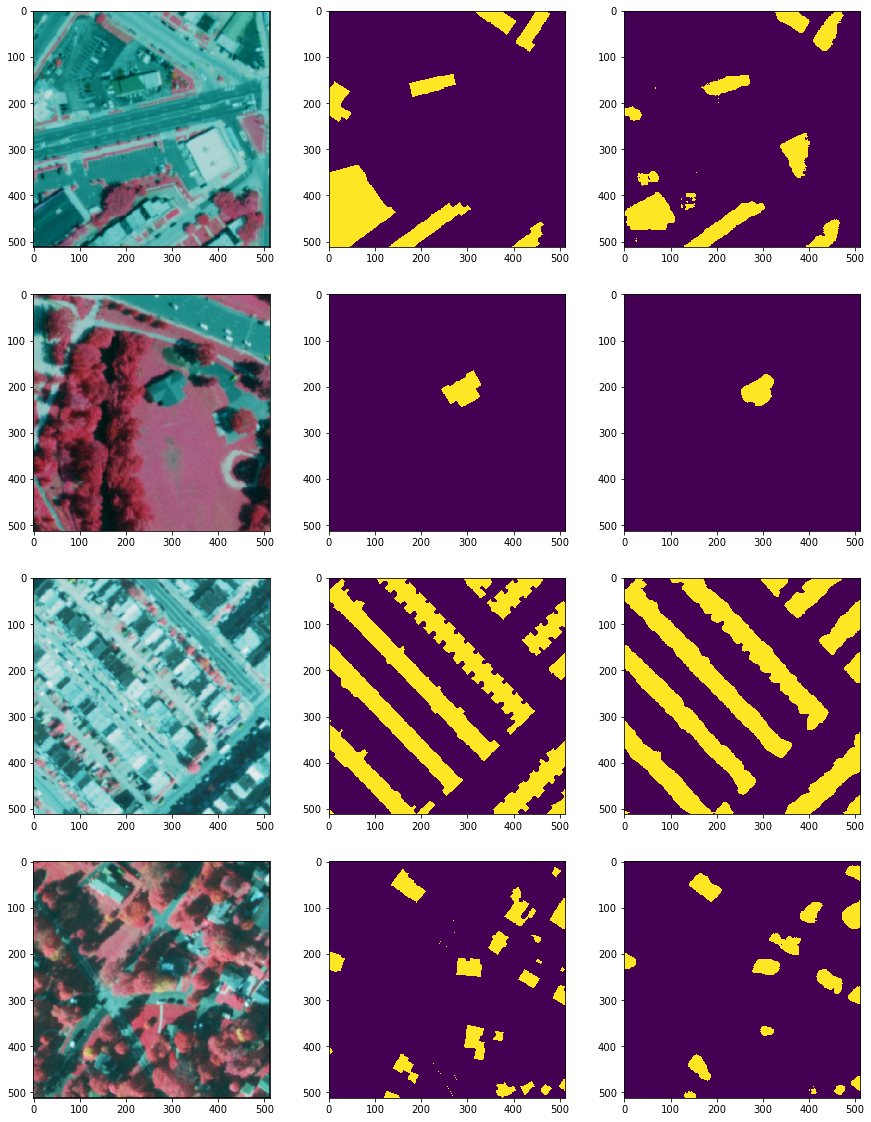

In [33]:
model = UNET(3,2)

model_path = r'/data/deeplearn-cities/code/unet_build_model100epc.pth'
model.load_state_dict(torch.load(model_path))

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb)

## batch size
bs = 4
fig, ax = plt.subplots(bs, 3, figsize=(15, bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))
    